## Facial Expression Recognition Challenge - FERC

### 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from numpy import asarray
import matplotlib.pyplot as plt
from IPython.display import SVG, Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

img_size, batch_size = 48, 64

### 2. Import & Explore Dataset

In [2]:
df = pd.read_csv("fer2013.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [3]:
df.head(2)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


#### Helper Function 01: Transform Emotion Column - Map Numerical Value to Actual Emotions 

In [4]:
# 7 Categories
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

def emotions_mapping(row):
    val = row["emotion"]
    if val == 0:
        return "Angry"
    elif val == 1:
        return "Disgust"
    elif val == 2:
        return "Fear"
    elif val == 3:
        return "Happy"
    elif val == 4:
        return "Sad"
    elif val == 5:
        return "Surprise"
    else:
        return "Neutral"

df["actual_emotion"] = df.apply(emotions_mapping, axis=1) 

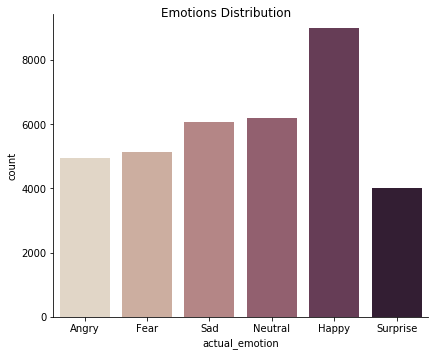

In [5]:
# drop disgust - decide to only work on 6 categories.

df = df[df.emotion != 1]
ax = sns.catplot(x="actual_emotion", kind="count", palette="ch:.25", data=df, height=5, aspect=1.2)
ax.fig.suptitle("Emotions Distribution")
ax

#### Helper Function 02: Reshape Pixels into Numpy Array

In [6]:
def transform_pixels(row):
    
    val = list(row["pixels"].split(' '))
    val = np.asarray(val, dtype=np.uint8)
    val = val.reshape((img_size, img_size))
    return val

df["numpy_pixels"] = df.apply(transform_pixels, axis=1) 

#### Split Data into Train & Test

In [7]:
train = df[df.Usage == "Training"]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28273 entries, 0 to 28708
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         28273 non-null  int64 
 1   pixels          28273 non-null  object
 2   Usage           28273 non-null  object
 3   actual_emotion  28273 non-null  object
 4   numpy_pixels    28273 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [8]:
test  = df[df.Usage != "Training"]
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7067 entries, 28709 to 35886
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         7067 non-null   int64 
 1   pixels          7067 non-null   object
 2   Usage           7067 non-null   object
 3   actual_emotion  7067 non-null   object
 4   numpy_pixels    7067 non-null   object
dtypes: int64(1), object(4)
memory usage: 331.3+ KB


#### Plot Training Images - Plot Directly Using Numpy Array, not from Image

In [9]:
train_plot = train.groupby(["actual_emotion"]).head(6)
train_plot_0 = train_plot[train_plot.emotion == 0]
train_plot_2 = train_plot[train_plot.emotion == 2]
train_plot_3 = train_plot[train_plot.emotion == 3]
train_plot_4 = train_plot[train_plot.emotion == 4]
train_plot_5 = train_plot[train_plot.emotion == 5]
train_plot_6 = train_plot[train_plot.emotion == 6]

In [10]:
t_list = [train_plot_0, train_plot_2, train_plot_3, train_plot_4, train_plot_5, train_plot_6]

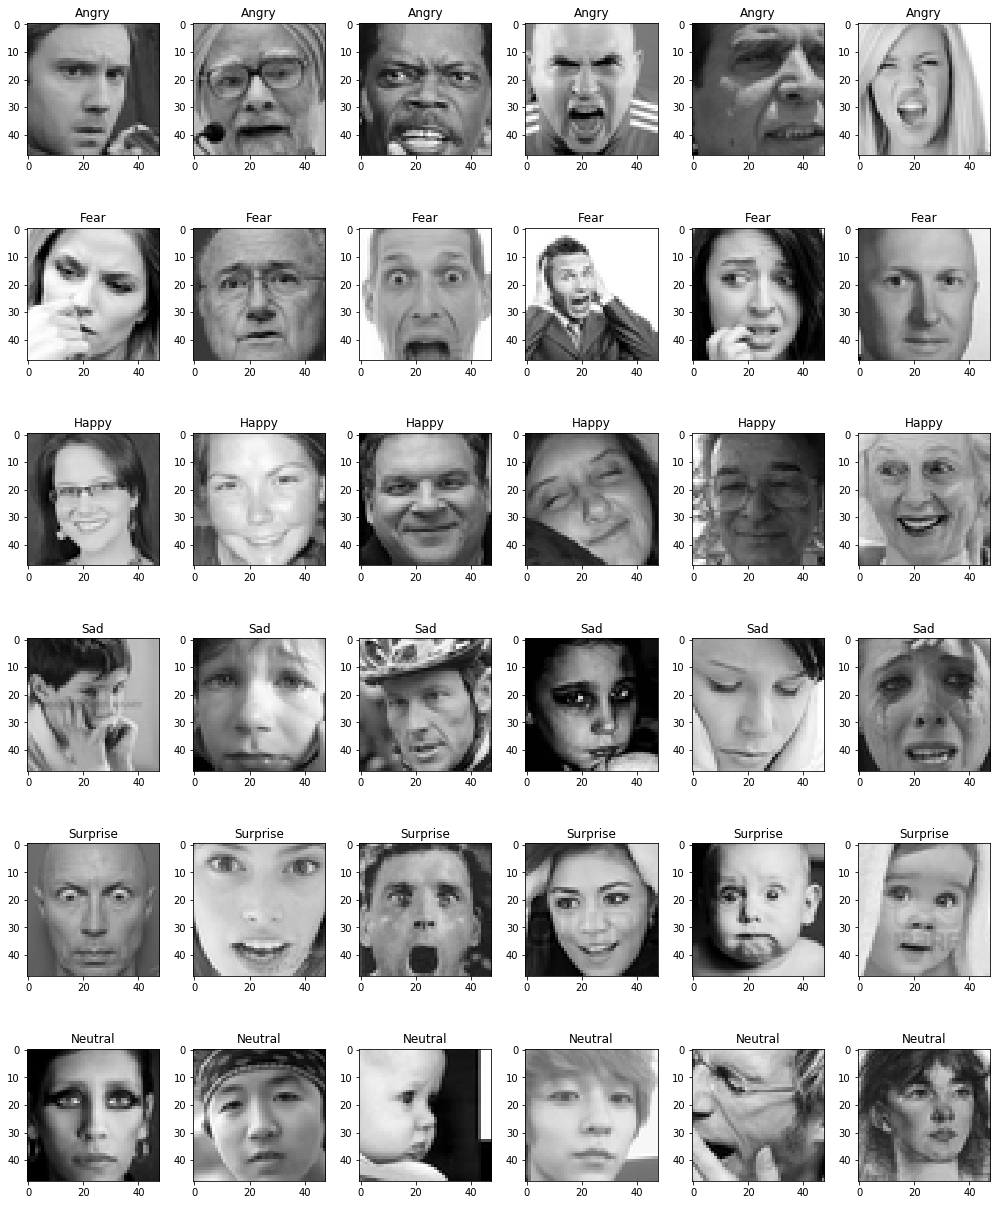

In [11]:
# Plot Images
from PIL import Image

plt.figure(0, figsize=(14, 20))
ctr = 0

for tl in t_list:
    for i, row in tl.iterrows():
        ctr += 1
        plt.subplot(7, 6, ctr, title=row["actual_emotion"])
        val = list(row["pixels"].split(' '))
        val = np.asarray(val, dtype=np.uint8)
        val = val.reshape((img_size, img_size))
        img = Image.fromarray(val)
        plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

#### Underlying Distribution - Bar Chart

In [12]:
train.actual_emotion.value_counts()

Happy       7215
Neutral     4965
Sad         4830
Fear        4097
Angry       3995
Surprise    3171
Name: actual_emotion, dtype: int64

In [13]:
test.actual_emotion.value_counts()

Happy       1774
Sad         1247
Neutral     1233
Fear        1024
Angry        958
Surprise     831
Name: actual_emotion, dtype: int64

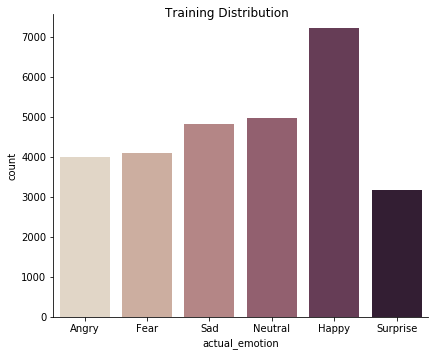

In [14]:
ax = sns.catplot(x="actual_emotion", kind="count", palette="ch:.25", data=train, height=5, aspect=1.2)
ax.fig.suptitle("Training Distribution")
ax

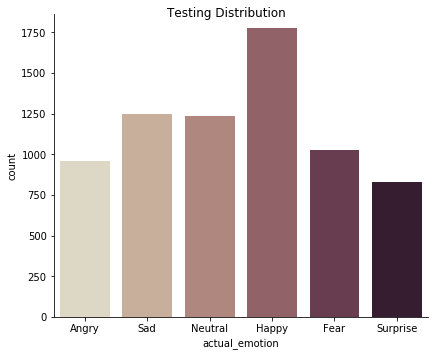

In [15]:
ax = sns.catplot(x="actual_emotion", kind="count", palette="ch:.34", data=test, height=5, aspect=1.2)
ax.fig.suptitle("Testing Distribution")
ax

#### Observation

- The dataset is incredibly imbalanced.

### 3. Generate Training & Validation Batches

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_gen = train_datagen.flow_from_directory("train/", target_size=(img_size, img_size), color_mode="grayscale", batch_size=batch_size, class_mode="categorical", shuffle=True)
validation_gen = validation_datagen.flow_from_directory("test/", target_size=(img_size, img_size), color_mode="grayscale", batch_size=batch_size, class_mode="categorical", shuffle=True)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


### 4. Create a CNN Model

In [17]:
model = Sequential()

# 1. Conv
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_size, img_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# 2. Conv Layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3. Conv Layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4. Conv Layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))
model.compile(optimizer=Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### 5. Train Model - 2 Diff Versions

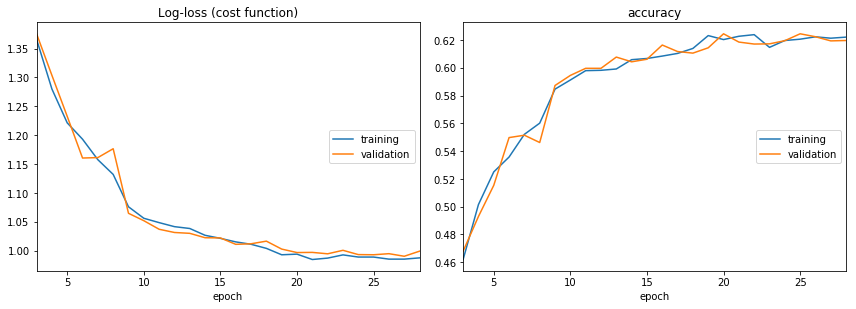

Log-loss (cost function):
training   (min:    0.985, max:    1.794, cur:    0.987)
validation (min:    0.990, max:    2.045, cur:    0.999)

accuracy:
training   (min:    0.284, max:    0.624, cur:    0.622)
validation (min:    0.204, max:    0.624, cur:    0.620)

Epoch 00028: saving model to model_weights_6cat_v2.h5
441/441 [==============================] - 2004s 5s/step - loss: 0.9874 - accuracy: 0.6220 - val_loss: 0.9990 - val_accuracy: 0.6196


In [18]:
# Version 2 - 6 emotions 

epochs = 28
steps_per_epoch = train_gen.n // train_gen.batch_size
validation_steps = validation_gen.n // validation_gen.batch_size

checkpoint = ModelCheckpoint("model_weights_v2.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')
callbacks=[PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(x=train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_gen, validation_steps=validation_steps, callbacks=callbacks)

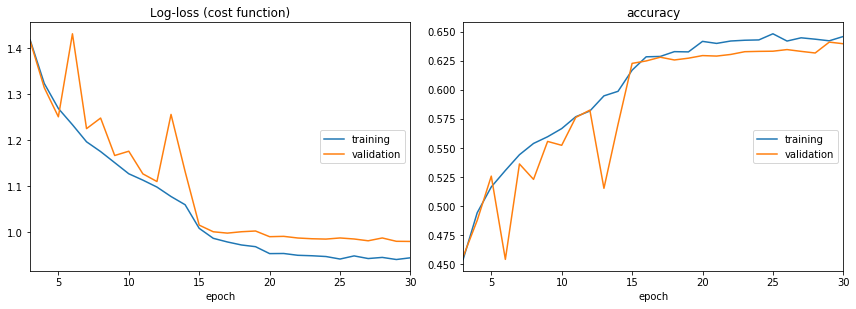

Log-loss (cost function):
training   (min:    0.941, max:    1.859, cur:    0.945)
validation (min:    0.980, max:    1.896, cur:    0.980)

accuracy:
training   (min:    0.283, max:    0.648, cur:    0.646)
validation (min:    0.274, max:    0.641, cur:    0.640)

Epoch 00030: saving model to model_weights.h5
448/448 [==============================] - 1089s 2s/step - loss: 0.9446 - accuracy: 0.6458 - val_loss: 0.9803 - val_accuracy: 0.6395


In [15]:
# version 1 - 7 emotions 

epochs = 30
steps_per_epoch = train_gen.n // train_gen.batch_size
validation_steps = validation_gen.n // validation_gen.batch_size

checkpoint = ModelCheckpoint("model_weights_v1.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')
callbacks=[PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(x=train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_gen, validation_steps=validation_steps, callbacks=callbacks)

### 6. Represents Model as JSON String

In [18]:
model1_json = model.to_json()

with open("model_v1.json", "w") as json_file1:
    json_file1.write(model1_json)

In [19]:
model2_json = model.to_json()

with open("model_v2.json", "w") as json_file1:
    json_file1.write(model2_json)